In [1]:
#library imports
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
# Load datasets
csv_file_path1 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/all-data.csv"
csv_file_path2 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv"

try:
    df1 = pd.read_csv(csv_file_path1, encoding='utf-8')
except UnicodeDecodeError:
    df1 = pd.read_csv(csv_file_path1, encoding='latin1')

try:
    df2 = pd.read_csv(csv_file_path2, encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv(csv_file_path2, encoding='latin1')

# Concatenate datasets
df = pd.concat([df1, df2], ignore_index=True)
# Data Preprocessing
stop_words = set(stopwords.words('english'))

In [3]:
#data preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

df['text'] = df['news'].apply(preprocess_text)
df['label'] = df['label'].apply(lambda x: x.lower())

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [4]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [5]:
# Word2Vec embeddings
sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=120, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((len(word2vec_model.wv), word2vec_model.vector_size))
for i in range(len(word2vec_model.wv)):
    embedding_vector = word2vec_model.wv[word2vec_model.wv.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [6]:
# Define custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, word2vec_model):
        self.texts = texts
        self.labels = labels
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        tokens = text.split()
        vec = np.zeros(self.word2vec_model.vector_size)
        for token in tokens:
            if token in self.word2vec_model.wv:
                vec += self.word2vec_model.wv[token]
        return torch.tensor(vec, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TextDataset(X_train, y_train, word2vec_model)
test_dataset = TextDataset(X_test, y_test, word2vec_model)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Define FeedForwardNN model architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, activation_function, dropout):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.dropout = nn.Dropout(dropout)
        self.activation_function = activation_function
        self.fc2 = nn.Linear(hidden_dims[-1], 3)  # 3 classes for sentiment analysis
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation_function(x)
            x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Model parameters
input_dim = 120  # word embedding vector size
hidden_dims = [300, 200] #number of hidden layers with dimensions
dropout = 0.4 #dropout rate
activation_function = nn.Sigmoid()  #activation rate 
lr = 0.001 #learning rate

# Initialize model, loss function, and optimizer
model = FeedForwardNN(input_dim, hidden_dims, activation_function, dropout)
criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(model.parameters(), lr=lr) #optimzer

In [8]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.9722
Epoch [2/20], Loss: 0.8418
Epoch [3/20], Loss: 0.8075
Epoch [4/20], Loss: 0.8947
Epoch [5/20], Loss: 0.9050
Epoch [6/20], Loss: 0.9621
Epoch [7/20], Loss: 0.9615
Epoch [8/20], Loss: 1.0239
Epoch [9/20], Loss: 0.9467
Epoch [10/20], Loss: 0.9458
Epoch [11/20], Loss: 0.8287
Epoch [12/20], Loss: 0.8829
Epoch [13/20], Loss: 0.8642
Epoch [14/20], Loss: 0.8466
Epoch [15/20], Loss: 0.7733
Epoch [16/20], Loss: 0.9042
Epoch [17/20], Loss: 1.0872
Epoch [18/20], Loss: 0.7798
Epoch [19/20], Loss: 0.8517
Epoch [20/20], Loss: 0.9631


In [9]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = outputs.cpu().numpy()  # Get predicted probabilities
        preds = np.argmax(probs, axis=1)  # Get predicted class labels
        
        all_probs.extend(probs)  
        all_preds.extend(preds)  
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Accuracy: 0.6306
Precision: 0.6305
Recall: 0.6306
F1 Score: 0.6170
              precision    recall  f1-score   support

    negative       0.58      0.32      0.41      3420
     neutral       0.59      0.79      0.68      5386
    positive       0.68      0.67      0.67      6626

    accuracy                           0.63     15432
   macro avg       0.62      0.59      0.59     15432
weighted avg       0.63      0.63      0.62     15432



The model performs best for the positive class with precision and recall around 0.68 and 0.67 respectively, indicating that it is fairly balanced in terms of precision and recall.

The neutral class has a precision of 0.59 and a recall of 0.79, suggesting that while it correctly identifies a high proportion of neutral instances (high recall), it also has a relatively high number of false positives (lower precision).

The negative class has the lowest performance with a precision of 0.58 and a recall of 0.32, indicating difficulty in correctly identifying negative instances and a high number of false negatives.

The overall accuracy of the model is 63%, indicating that the model correctly classified 63% of all instances.

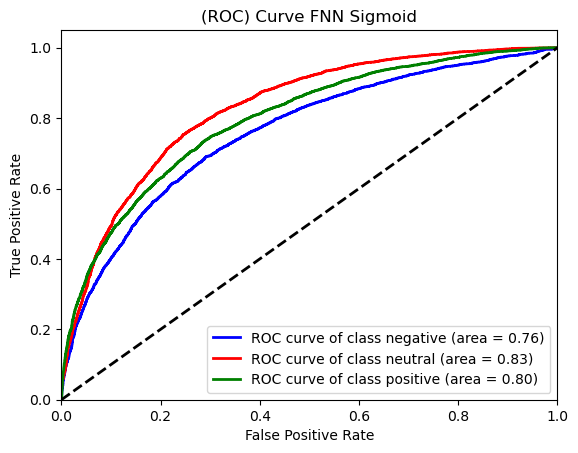

In [10]:
# Binarize the labels for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score_bin = np.array(all_probs)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve FNN Sigmoid')
plt.legend(loc="lower right")
plt.show()

As compared to more advanced model, the ROC curve is not that good. However it is able to distingush between classes